# "Mount & Blade II: Bannerlord" Analysis Code

## All code written in Python and outputs are created with PyPlot. 

I chose to write the code in Python since I believe it's best to manipulate and present the data. Python functions allow me to repeat tasks without having to write code repeatedly. I used Pandas to structure and manipulate the data, and PyPlot and Seaborn to visualize the data. 

The goal of this analysis is to find the best performing shield infantry unit when fighting against other shield infantry units. The key performance metric that will be examined is the kill-death-ratio (KDR), which measure the number of kill for each death per unit. For example, if a Legionary has two kills before he perishes, then his KDR is 2.0. Another key performance metric to analyze is the win rate, which is the number of wins divided by thet total number of matches. 

In the cell below are the Pandas, PyPlot, and Seaborn modules used throught this analysis. The CSV data has been pre-processed with [this script available on GitHub](https://github.com/mdane117/bannerlord/blob/main/shield_infantry_analysis/infantry_data_processor.py). The pre-processing includes:
- Introduced additional columns, unit_id and opponent_id, to uniquely identify each unit and opponent, respectively. This addition aids in more precise data manipulation and referencing.
- Refined the logic of the ‘status’ column by backfilling matches to accurately identify wins and losses. This modification allows for an analysis based on wins and losses.
- Implemented logic to include reverse matchups to normalize the data. While StratGaming’s original data contained records for matchups like Legionary vs. Darkhan, it lacked the reverse, i.e., Darkhan vs. Legionary. Since the designation of ‘unit’ and ‘opponent’ is arbitrary in the context of analysis, I added records for these reverse matchups to maintain consistency in the dataset. This step involved backfilling the ‘kills’ and ‘deaths’ columns, inverting the win/loss status where necessary, and recalculating the ‘kill_rate’, ‘death_rate’, and ‘kdr’ for the new records.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('shield_infantry_processed_data.csv')

# For this analysis, we will focus on the KDR and win rates for units. The functions are also designed to analyze other metrics if needed. 

## Functions

### get_mean()
This function takes a dataframe as an argunment and aggregates the unit by average KDR and returns a table.

### get_std()
This function takes a dataframea s an argument and aggregates the unit by the standard deviation of KDR and returns a table.

### remove_outliers()
This function uses the get_mean() and get_std() functions to remove outliers. Outliers are defined as KDR values above/below +/- 3 standard deviations. The output is a dataframe with the outliers removed. This way any outlier KDRs won't skew the data heavily. However, the downside is that removing outliers means that samples are smaller. 

### create_bar()
This function takes a table and a graph title and generates a bar chart. This is commonly used with the output of the get_mean() function after applying remove_outliers() to the data. 

### create_heatmap()
This function takes a dataframe and a graph title and generates a heatmap. It aggregates data into a pivot table based on mean KDR and then displays it with a color map for easier viewing. 

In [38]:
# Function that gets the mean KDR for each unit
def get_mean(data):
    mean_df = data.groupby(['unit', 'unit_id'])['kdr'].mean().sort_values().reset_index() 
    return mean_df

# Function that gets the standard deviation of KDR for each unit
def get_std(data):
    std_df = data.groupby(['unit', 'unit_id'])['kdr'].std().sort_values().reset_index() 
    return std_df

# This function will remove KDR outliers that are +/- 3 standard deviations from the mean for each unit
def remove_outliers(data):
    mean_df = get_mean(data)
    std_df = get_std(data)

    # Merge the mean and standard deviation DataFrames with the original data
    merged_df = data.merge(mean_df, on=['unit', 'unit_id'], suffixes=('', '_mean'))
    merged_df = merged_df.merge(std_df, on=['unit', 'unit_id'], suffixes=('', '_std'))

    # Calculate the lower and upper bounds for outliers
    merged_df['lower_bound'] = merged_df['kdr_mean'] - 3 * merged_df['kdr_std']
    merged_df['upper_bound'] = merged_df['kdr_mean'] + 3 * merged_df['kdr_std']

    # Filter out outliers
    filtered_df = merged_df[(merged_df['kdr'] >= merged_df['lower_bound']) & (merged_df['kdr'] <= merged_df['upper_bound'])]

    # Return the filtered DataFrame
    return filtered_df

# This function will create bar charts for any tables generated from get_mean()
def create_bar(table, title): # title is a argument that will assign the title of the bar chart
    # This plot visualizes the KDR for all units that were tested
    non_infantry = [9, 10, 11, 12]
    plt.figure(figsize=(20, 6))  # Optional: Adjust the figure size
    
    # Create empty lists to store the bar objects for each category
    shield_infantry_bars = []
    non_standard_infantry_bars = []
    
    # Iterate over the rows of the DataFrame and set the color based on whether the unit_id is in non_infantry
    for i, row in table.iterrows():
        unit, unit_id, kdr = row['unit'], row['unit_id'], row['kdr']
        color = '#e49444' if unit_id in non_infantry else '#5778a4'
        bar = plt.bar(x=i, height=kdr, color=color)
        if unit_id in non_infantry:
            non_standard_infantry_bars.append(bar)
        else:
            shield_infantry_bars.append(bar)
    
    plt.xlabel('Unit')  # Label for the x-axis
    plt.ylabel('KDR')  # Label for the y-axis
    plt.title(title)  # Title of the plot
    plt.xticks(ticks=range(len(table)), labels=table['unit'], rotation=45)  # Set x-axis labels to unit names
    
    # Annotate each bar with its value
    for i, row in table.iterrows():
        yval = row['kdr']
        plt.text(i, yval + 0.01, round(yval, 2), ha='center', va='bottom')
    
    # Create a custom legend only if there are bars in each category
    if shield_infantry_bars and non_standard_infantry_bars:
        plt.legend([shield_infantry_bars[0], non_standard_infantry_bars[0]], ['Shield Infantry Unit', 'Non-Infantry Unit'])
    
    plt.show()

def create_heatmap(data, title):
    # Create a pivot table with the mean KDR for each unit-opponent combination
    pivot_table = data.pivot_table(values='kdr', index='unit', columns='opponent', aggfunc='mean')

    # Set the size of the heatmap
    plt.figure(figsize=(12, 10))

    # Create the heatmap using seaborn, with annotations and a color map of 'coolwarm'
    ax = sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt=".2f")

    # Set the title of the heatmap
    plt.title(title)

    # Set the labels for the x-axis and y-axis
    plt.xlabel('Opponent')
    plt.ylabel('Unit')

    # Rotate the x-axis tick labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.show()
    

## Mean KDR for each unit

The code and graph below uses the get_mean() and create_bar() functions to generate this bar chart. The bar chart shows the mean KDR of every unit that was observed during data collection. Note that we have two types of units; the shield infantry unit and the non-infantry unit. 

Keep in mind that the non-infantry units are dismounted (on foot), and do not use any ranged capabilities in testing, but in Bannerlord they are not classified as infantry. The Imperial Sergeant Crossbowmen and Fian Champions are classified as archers, the Elite Cataphract are cavalry, and the Khan's Guard are horse archers. 

The highest KDRs are the Khan's Guards, Legionary, and Fian Champions with 6.99, 6.64, and 5.81 KDR, repsectively. The fourth highest has a significant gap at 2.87. The top three units are clearly efficient fighters, but it is significant to note that two of the three are not infantry units. Khan's Guards and Fian Champions are both equipped with bows and two-handed weapons, while the Legionary are equipped with a one-handed sword and shield. Perhaps the use of two-handed weapons increases the killing efficieny of units, but that is to be determined in another analysis. 

The Wildlings, Mixed Infantry, and Oathsworn are the bottom three with under 1 KDR. I did not expect the Wildling to underperform this much. 

It's worth noting that the Mixed Infantry are mixed between lower tier troops, and that their unit count is at 667. This is because the shield infantry units being tested are at their highest tier (fully upgraded troops), so their cost per unit is higher. Therefore, to make the Mixed Infantry seem "fair", the number of troops increased until the cost matches. 

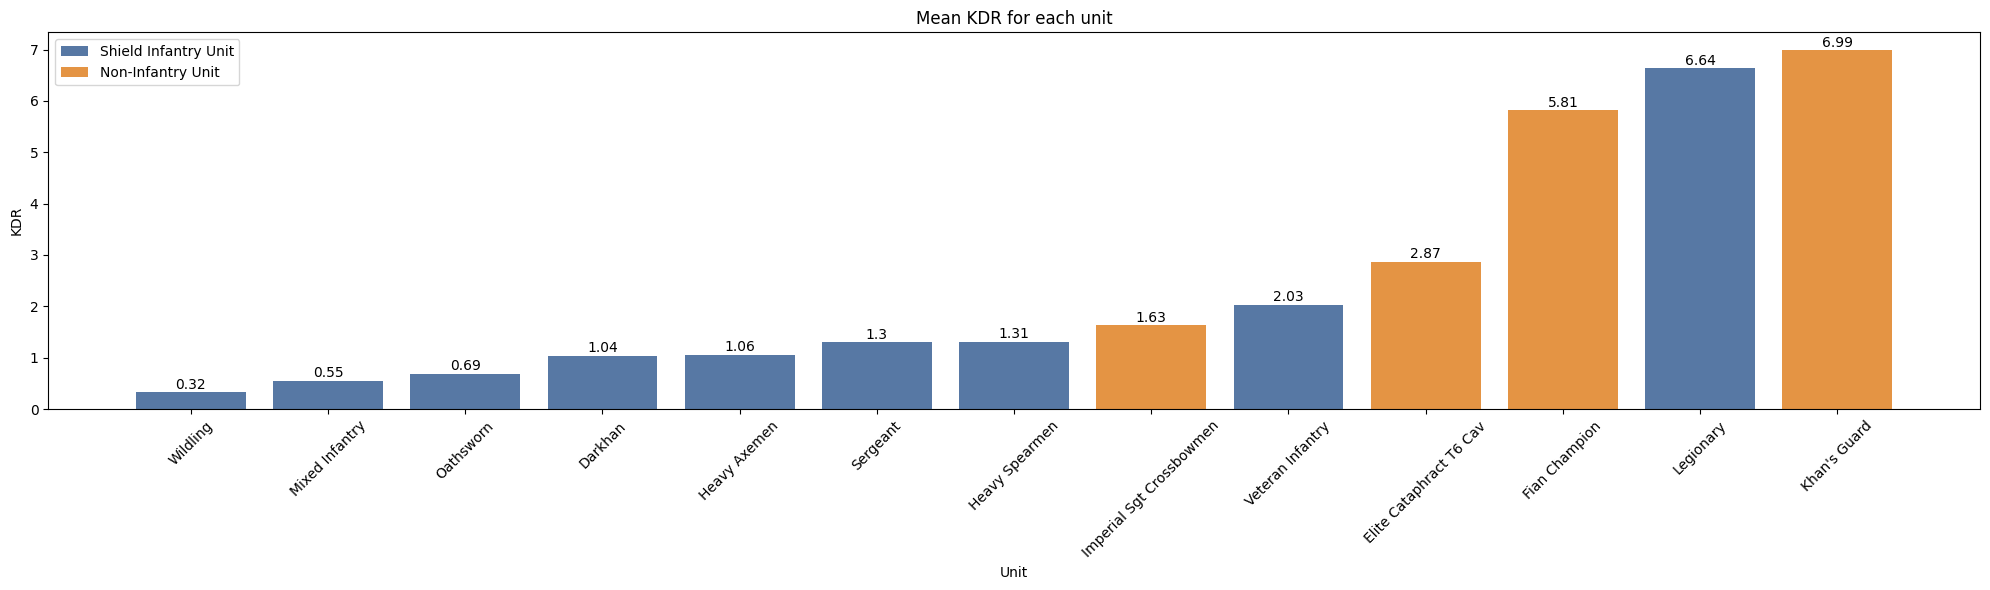

In [20]:
table_0 = get_mean(df)
title_0 = 'Mean KDR for each unit'
create_bar(table_0, title_0)

## Mean KDR for each unit without outliers

The outliers are considered +/- 3 sigma (three standard deviations) from the mean, which means we removed the greatest of outliers. 2 sigma would remove too much data, therefore too small of a sample size. 

I expected that the top three performers in KDR would drop significantly after removing outliers, however the Legionary dropped from second in KDR to third, and by almost two from 6.64 to 4.69. The Khan's Guards and Fian Champions to drop significantly too, but they dropped from 6.99 to 6.6 and 5.81 to 5.68 respectively. This means that the Legionary had some large KDRs in some match ups that bloated their KDR values. 

There is not much movement or decreases in values for the other units, except Sergeants took the 7th spot and pushed the Heavy Spearmen down to 8th. 

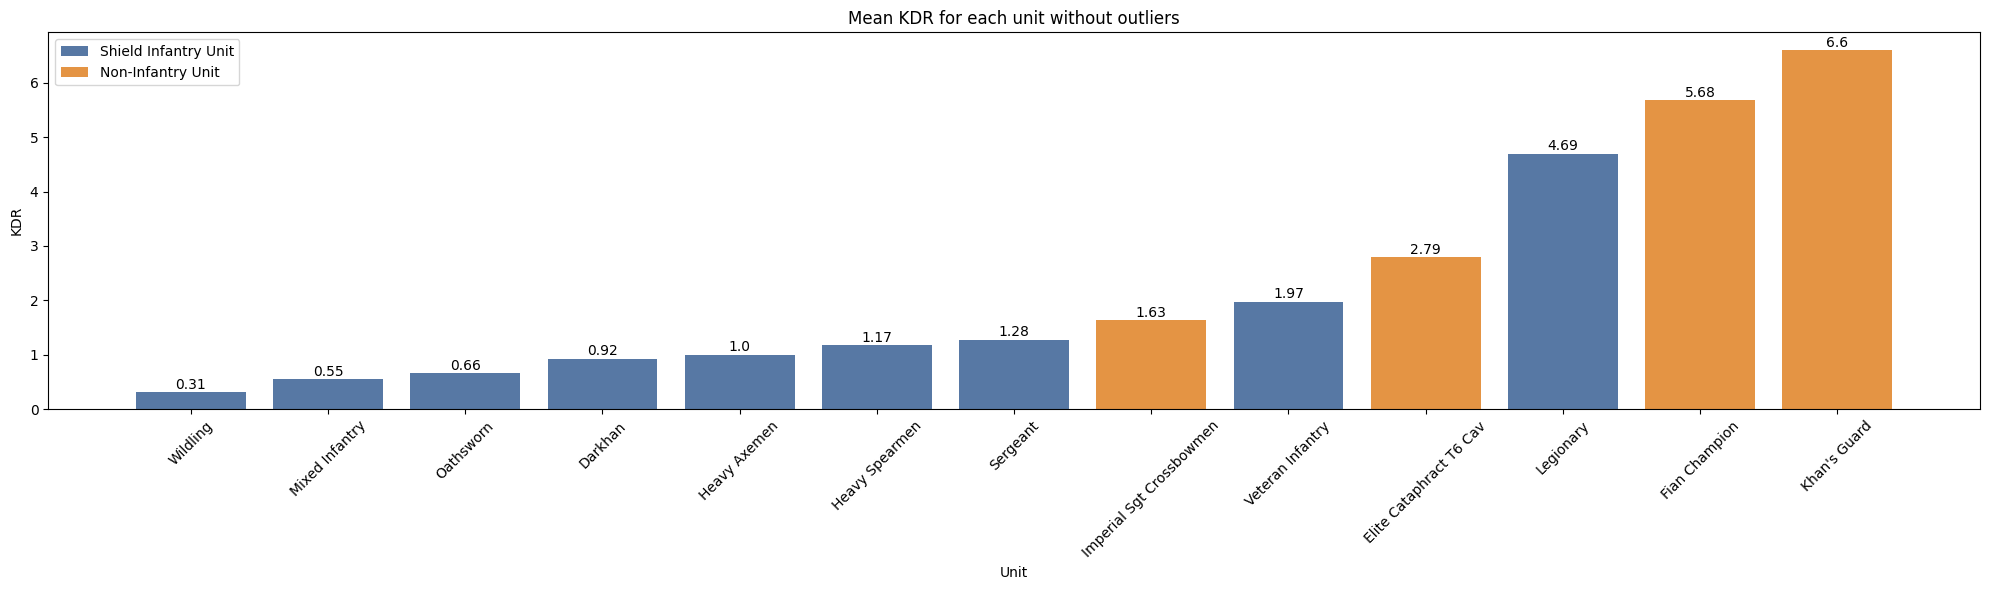

In [21]:
df_1 = remove_outliers(df)
table_1 = get_mean(df_1)
title_1 = 'Mean KDR for each unit without outliers'
create_bar(table_1, title_1)

## Mean KDR for shield infantry units only without outliers

I filtered the data so we only see the shield infantry KDR averages, and Legionary units are in first place, more than doubling the Veteran Infantry who have the second highest KDR. It still seems unreasonable that the Legionary are outperforming all other shield infantry units by such a wide margin. 

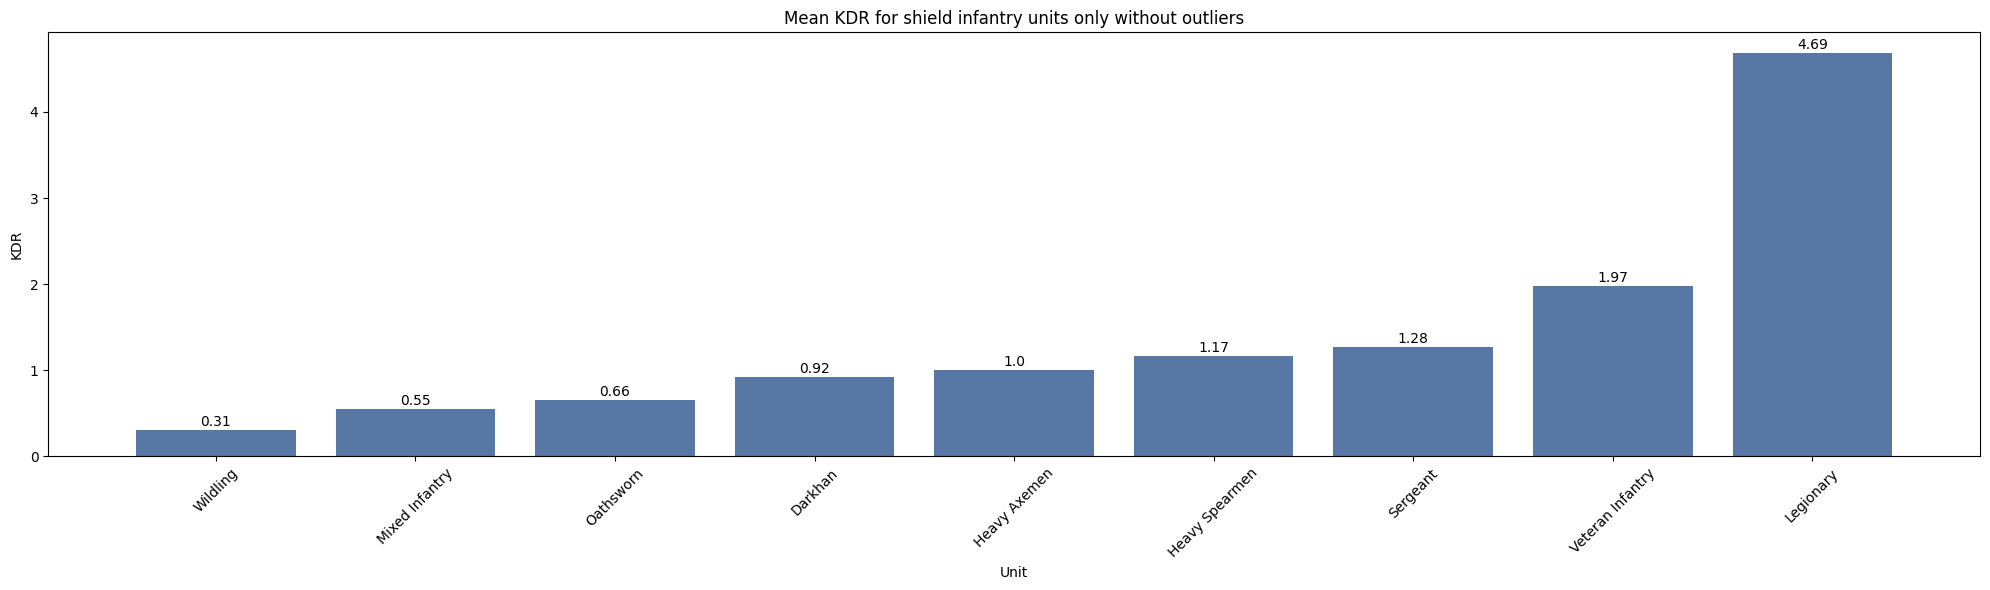

In [22]:
units_to_include = [1, 2, 3, 4, 5, 6, 7, 8, 13]
df_2 = df_1[df_1['unit_id'].isin(units_to_include)]
table_2 = get_mean(df_2)
title_2 = 'Mean KDR for shield infantry units only without outliers'
create_bar(table_2, title_2)

## Removing non-infantry unit data

I removed the non-infantry units (Khan's Guards, Fian Champions, Elite Cataphracts, and Imperial Sergeant Crossbowmen) from the dataframe to evaluate only the shield infantry data, then removed the outliers, and then calculated the mean KDR. I expected the values to increase across the board, but I was surprised that only the Legionary had a significant increase from 4.69 to 7.43. The Veteran Infantry increased from 1.97 to 2.77, and then the Heavy Spearmen overtook the Sergeants to get their third place spot again. No surprise by the increased values, but surprised by how small the increase is for the low-end shield infantry units.

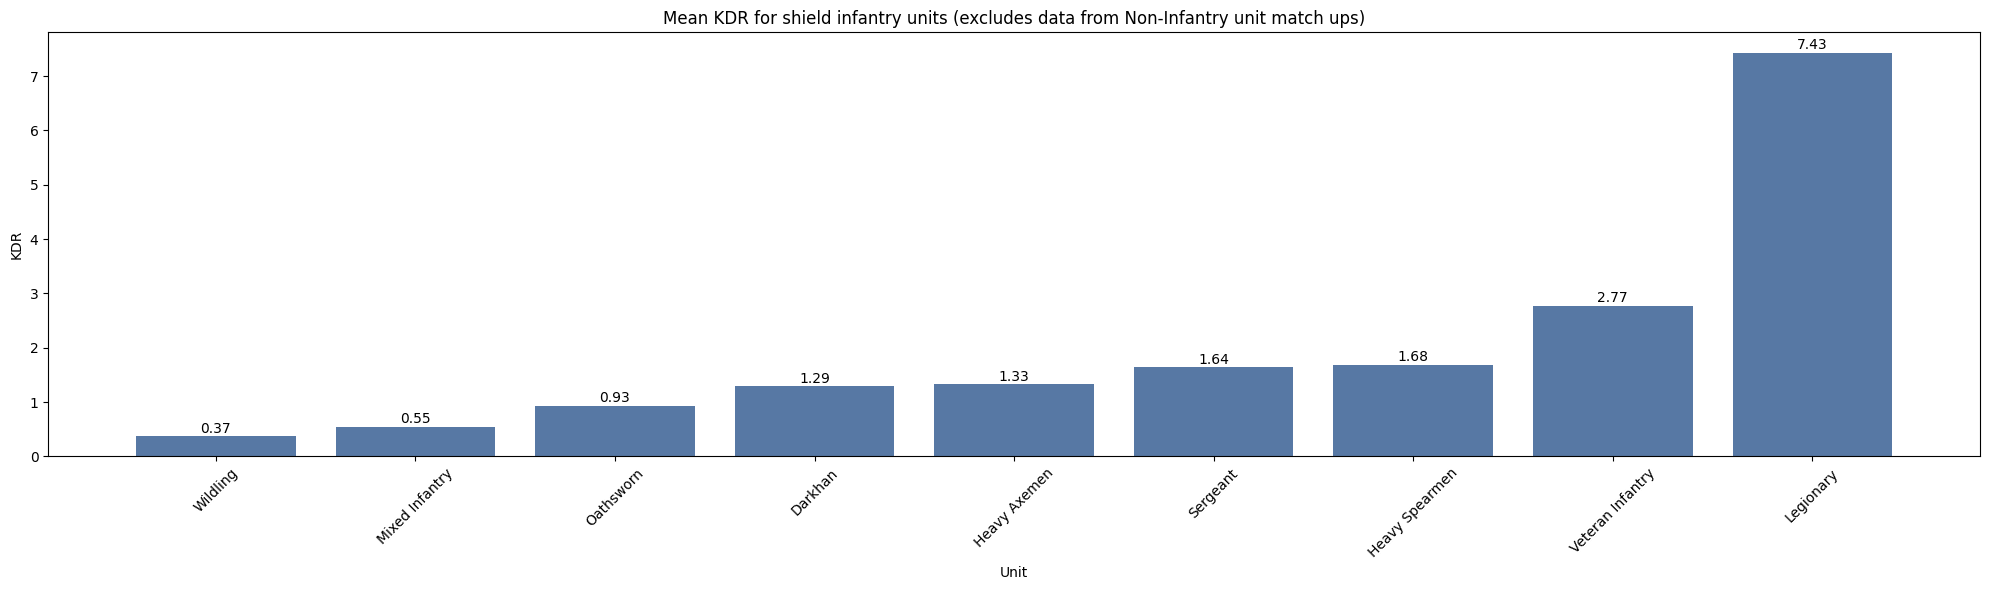

In [23]:
units_to_include = [1, 2, 3, 4, 5, 6, 7, 8, 13]
df_3 = df[df['unit_id'].isin(units_to_include)]
df_3 = df_3[df_3['opponent_id'].isin(units_to_include)]
df_3 = remove_outliers(df_3)
table_3 = get_mean(df_3)
title_3 = 'Mean KDR for shield infantry units (excludes data from Non-Infantry unit match ups)'
create_bar(table_3, title_3)

## Heatmap for mean KDR of individual shield infantry unit match ups

I wanted to see why the Legionary performed so well when exlcuding non-infantry units, so I created a heatmap that uses a pivot table that aggregates by the mean KDR of each unit. The Legionary have a KDR for 39.21 against the Heavy Axemen which greatly inflates their KDR, when we see KDR range from around 0.3 to 3.0. This still seems like a significant outlier despite removing them from the dataset. The skew is so great that the color-coding shows only a single red tile and the rest are deep blue tiles. 

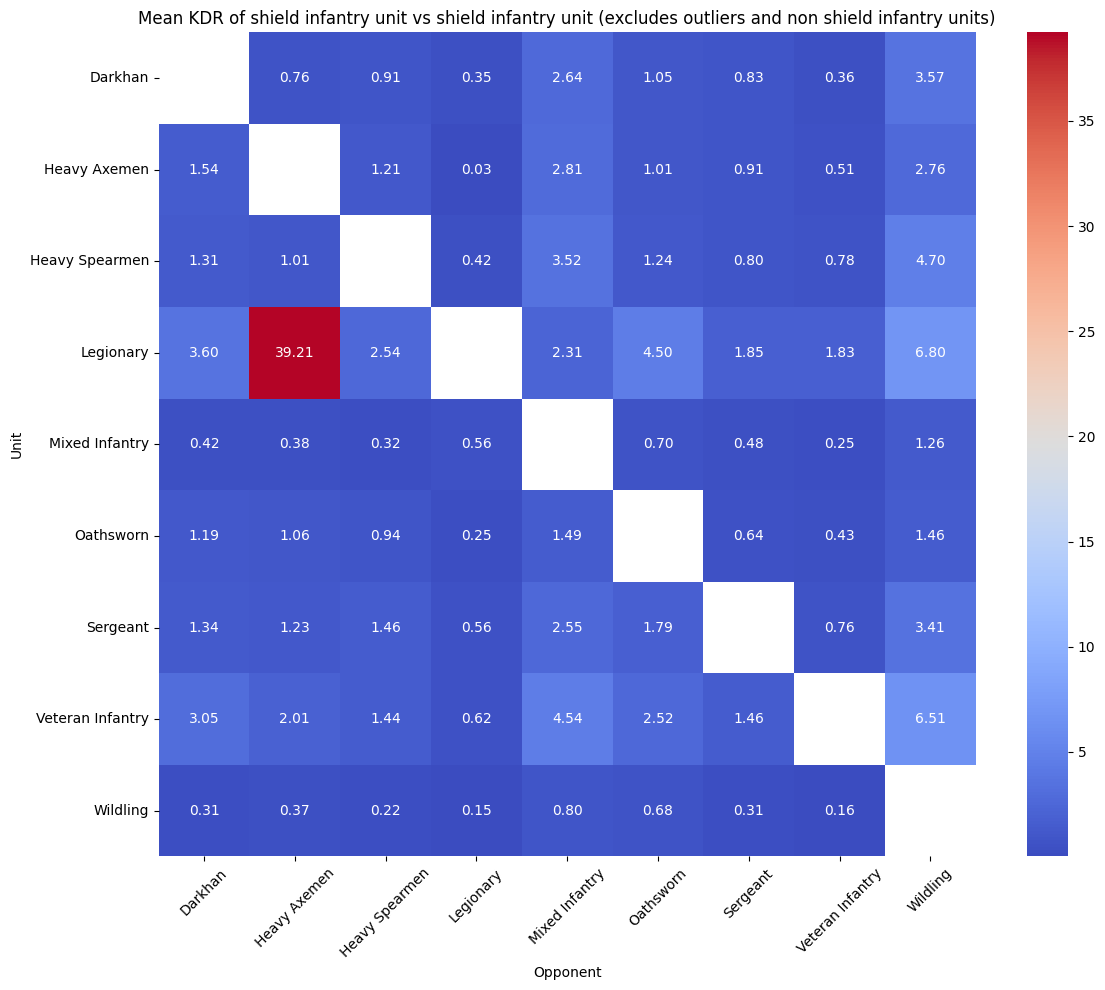

In [35]:
title_4 = 'Mean KDR of shield infantry unit vs shield infantry unit (excludes outliers and non shield infantry units)'
create_heatmap(df_3, title_4)

## Legionary vs Heavy Axemen match up

The Legionary vs Heaxy Axemen match up greatly favors the Legionary, where we have nine match ups with at least a 16 KDR, far higher than the average for Legionary. Considering that there are nine match ups and not ten, which means that there was one record that was above the 3 standard deviation cut off when filtering out. The Legionary decimated the Heavy Axemen. 

In [10]:
axemen = df_3[(df_3['unit_id'] == 1) & (df_3['opponent_id'] == 7)]
print(axemen[['unit', 'unit_id', 'opponent', 'opponent_id', 'kdr']])

         unit  unit_id      opponent  opponent_id    kdr
50  Legionary        1  Heavy Axemen            7  50.75
51  Legionary        1  Heavy Axemen            7  27.83
53  Legionary        1  Heavy Axemen            7  51.50
54  Legionary        1  Heavy Axemen            7  44.40
55  Legionary        1  Heavy Axemen            7  25.63
56  Legionary        1  Heavy Axemen            7  71.00
57  Legionary        1  Heavy Axemen            7  16.42
58  Legionary        1  Heavy Axemen            7  23.00
59  Legionary        1  Heavy Axemen            7  42.40


## Removing Legionary from the dataset

I removed the Legionary from the dataset to get a better idea of how the other units performed against each other. The Veteran Infantry had a minimum of 1.44 KDR against the Heavy Spearmen and a high of 6.51 against the Wildlings. Since Veteran Infantry did not below 1 in KDR against all other units, it makes it a formidable against other shield infantry. The next is the Sergeant with similar KDRs, and the only KDR below 1 is against the Veteran Infantry. The Heavy Spearmen and Axemen had similar KDR, while the Oathsworn had 3 sub 1 KDRs and the Darkhan 4 of them. The Wildling did not have a single average that is above 1 KDR, making it the least efficient unit out of them all. 

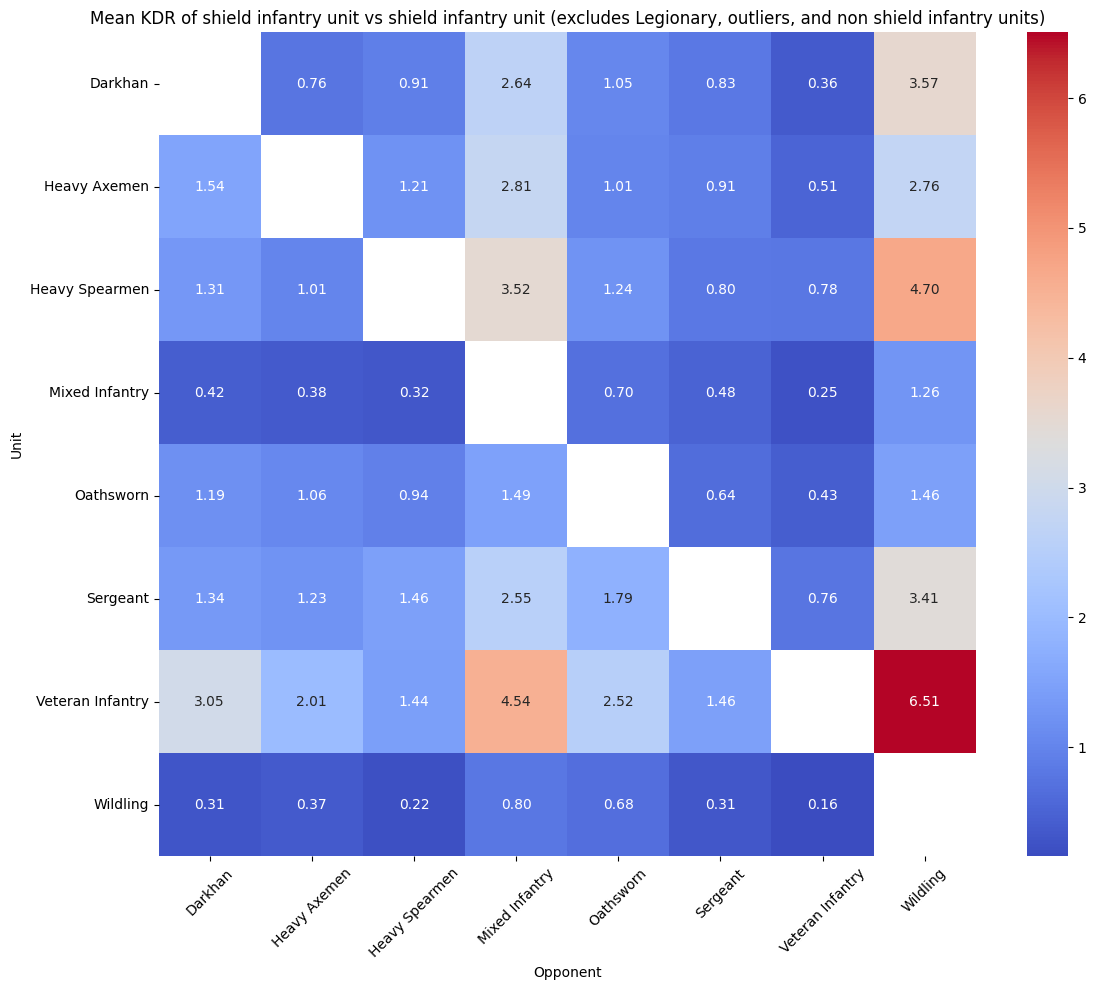

In [36]:
units_to_include = [2, 3, 4, 5, 6, 7, 8, 13] # Excludes Legionary units
df_4 = df[df['unit_id'].isin(units_to_include)]
df_4 = df_4[df_4['opponent_id'].isin(units_to_include)]
df_4 = remove_outliers(df_4)
title_5 = 'Mean KDR of shield infantry unit vs shield infantry unit (excludes Legionary, outliers, and non shield infantry units)'
create_heatmap(df_4, title_5)

## Removing Heavy Axemen from the dataset

I wanted to see how the Legionary do if the Heavy Axemen were removed from the dataset. The Legionary has an above 1 KDR against all units, with the lowest being 1.83. The Veteran Infantry also have >1 KDR against all other units exception against the Legionary, and then the Sergeant has the third most with the <1 KDRs against the Legionary and Veteran Infantry. By this stage, it seems clear that there is a top 3 amongst the 8 shield infantry units. 

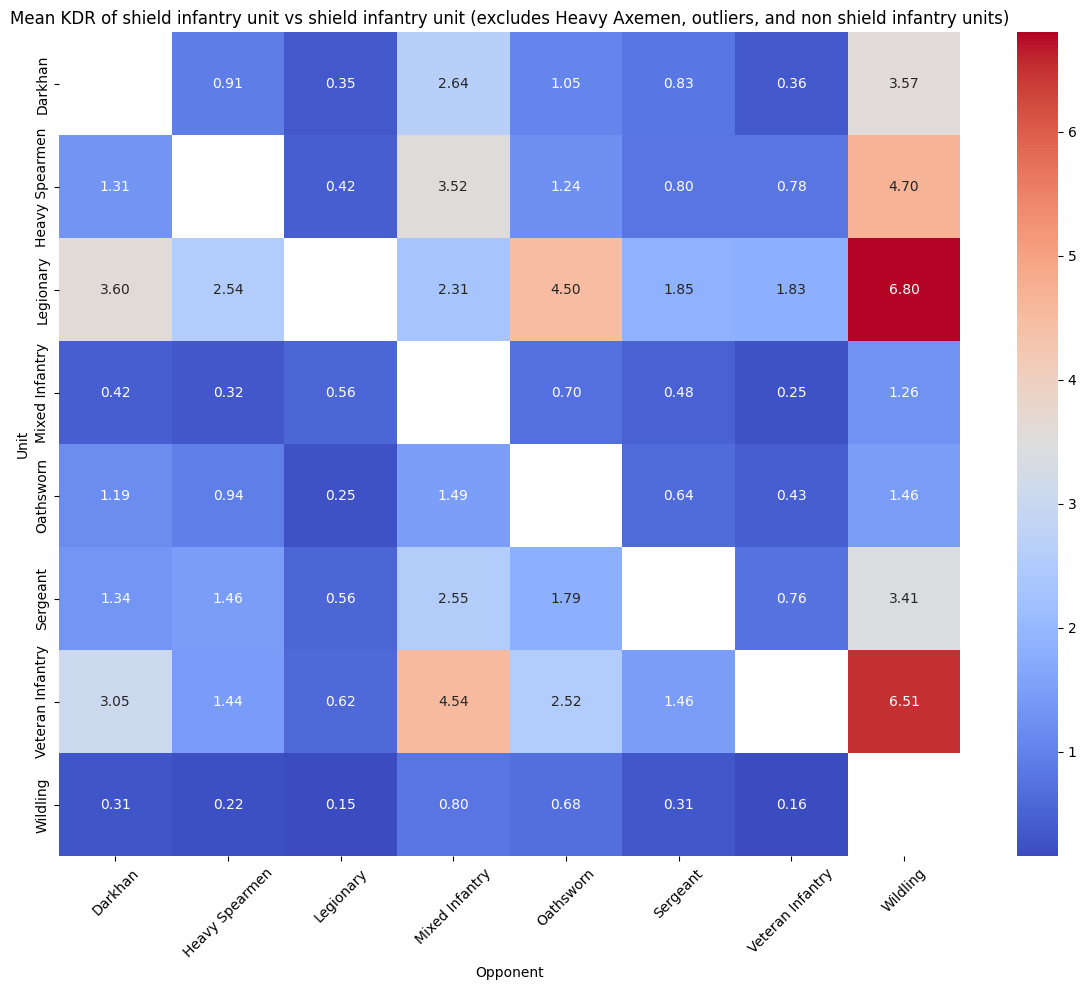

In [37]:
units_to_include = [1, 2, 3, 4, 5, 6, 8, 13] # Excludes Heavy Axemen
df_5 = df[df['unit_id'].isin(units_to_include)]
df_5 = df_5[df_5['opponent_id'].isin(units_to_include)]
df_5 = remove_outliers(df_5)
title_6 = 'Mean KDR of shield infantry unit vs shield infantry unit (excludes Heavy Axemen, outliers, and non shield infantry units)'
create_heatmap(df_5, title_6)

## Bar chart of average KDR exlcuding Heavy Axemen

The mean KDR for the Legionary and Veteran Infantry is a lot closer than initially observed in the first bar chart. The Legionary has a 3.35 average KDR and the Veteran Infantry is in second with 2.88. Then, there is a siginificant drop from the Veteran Infantry to the Heavy Spearmen at 1.78. Even though the Heavy Spearmen has a higher overall average KDR, the Sergeants have more >1 KDR against other units. I think that the KDR of a unit does not paint the full picture, so it is worth exploring the win rate for each unit. 

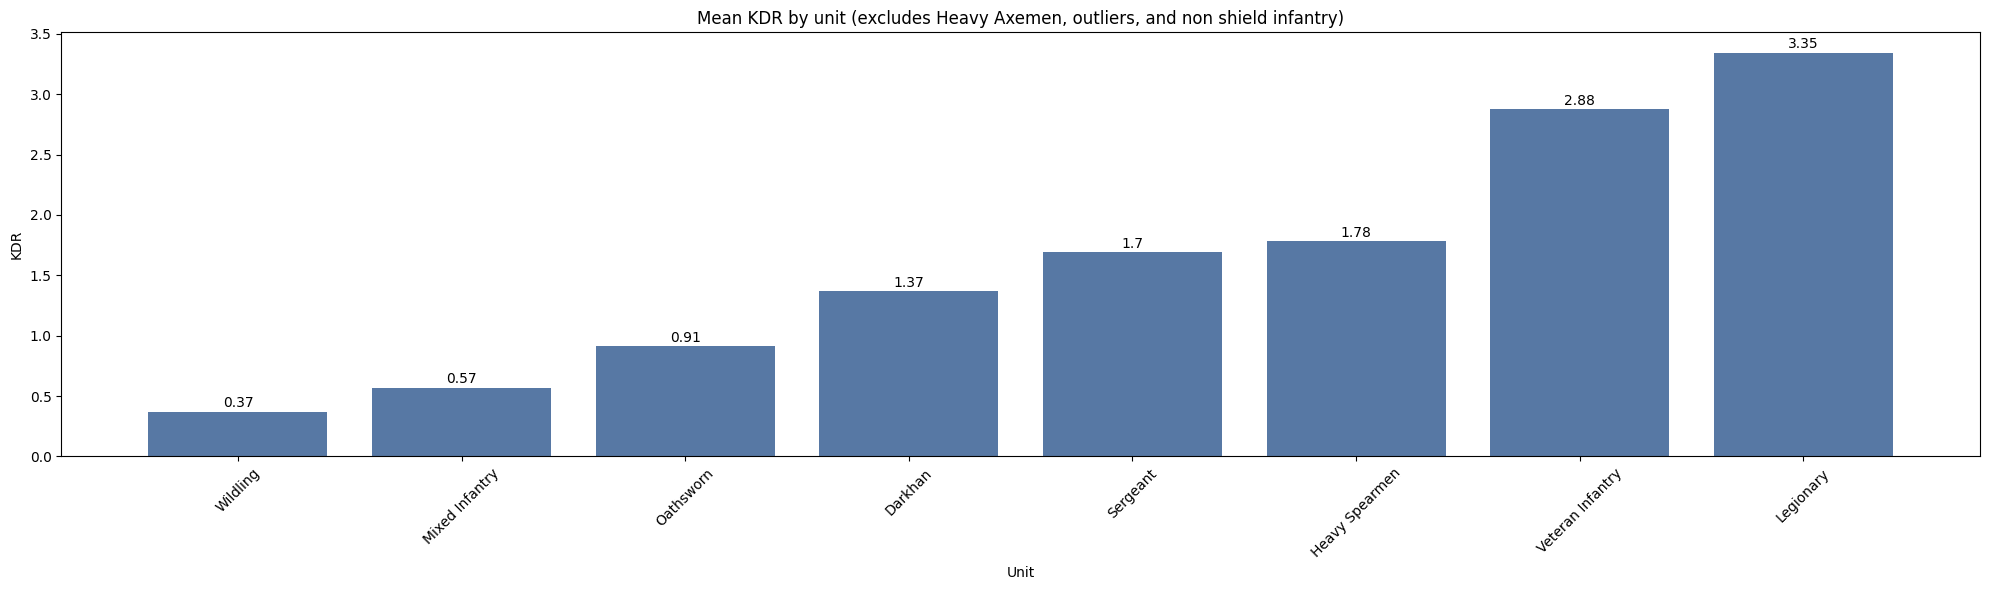

In [27]:
table_4 = get_mean(df_5)
title_7 = 'Mean KDR by unit (excludes Heavy Axemen, outliers, and non shield infantry)'
create_bar(table_4, title_7)

## Average win rate for shield infantry units only

The chart below shows the win rate (number of wins divided by total match ups). The outlier KDRs were kept in this dataset, since the KDR is a measure of efficiency rather than outcome. It does not really matter if the win was with a 1.01 KDR or a 50 KDR. 

The Legionary have a 90% win rate, Veteran Infatry at 82%, and Sergeants at 60%. The Heavy Axemen, Spearmen, and Mixed Infantry have a 49% win rate. Even though the Heavy Spearmen have a higher KDR than the Sergeant, they win less than half the time. The Oathsworn and Darkhan have 35% and 32% win rates, respectively. Finally, the Wildling has a 0% win rate. 

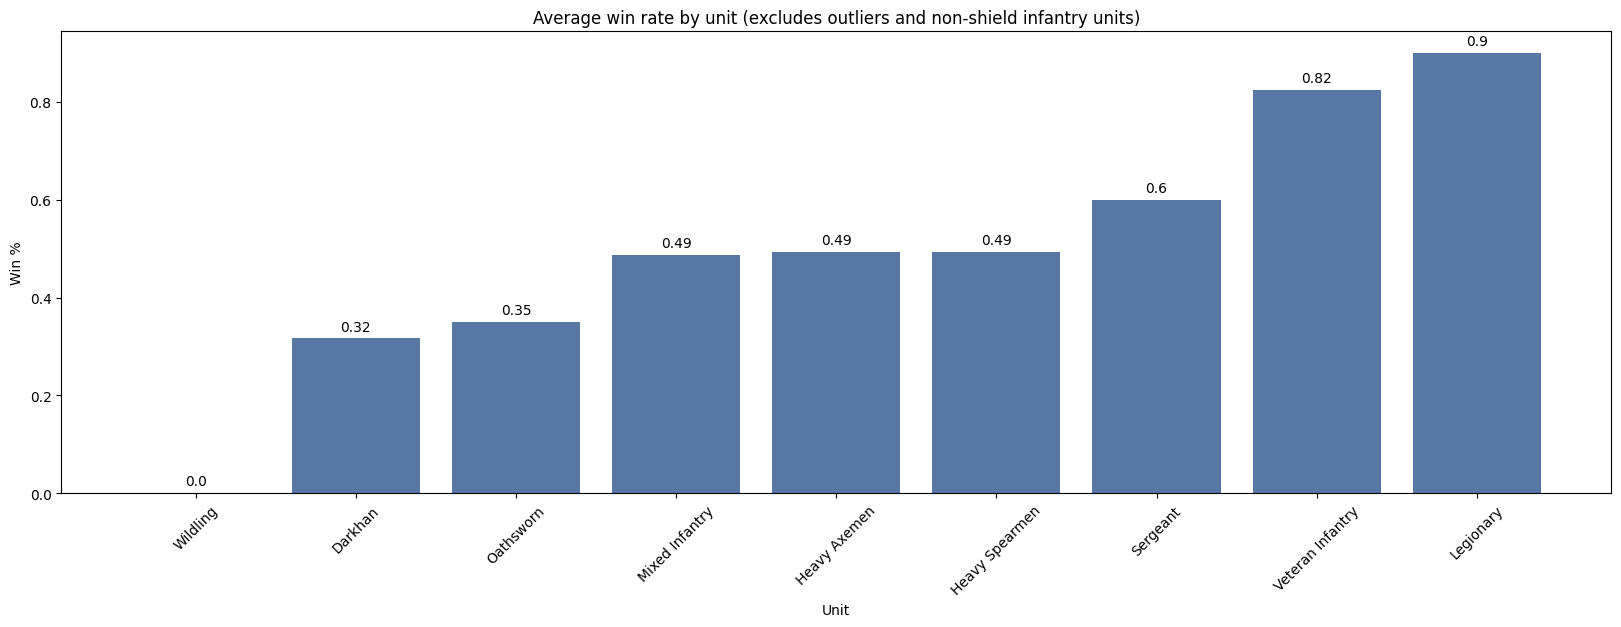

In [31]:
df_3['win'] = df_3['status'].apply(lambda x: 1 if x == 'Win' else 0)
table_5 = df_3.groupby(['unit', 'unit_id'])['win'].mean().sort_values().reset_index()
title_8 = 'Average win rate by unit (excludes outliers and non-shield infantry units)'

non_infantry = [9, 10, 11, 12]
plt.figure(figsize=(20, 6))  # Optional: Adjust the figure size
    
# Create empty lists to store the bar objects for each category
shield_infantry_bars = []
non_standard_infantry_bars = []
    
# Iterate over the rows of the DataFrame and set the color based on whether the unit_id is in non_infantry
for i, row in table_5.iterrows():
    unit, unit_id, win = row['unit'], row['unit_id'], row['win']
    color = '#e49444' if unit_id in non_infantry else '#5778a4'
    bar = plt.bar(x=i, height=win, color=color)
    if unit_id in non_infantry:
        non_standard_infantry_bars.append(bar)
    else:
        shield_infantry_bars.append(bar)
    
plt.xlabel('Unit')  # Label for the x-axis
plt.ylabel('Win %')  # Label for the y-axis
plt.title(title_8)  # Title of the plot
plt.xticks(ticks=range(len(table_5)), labels=table_5['unit'], rotation=45)  # Set x-axis labels to unit names
    
# Annotate each bar with its value
for i, row in table_5.iterrows():
    yval = row['win']
    plt.text(i, yval + 0.01, round(yval, 2), ha='center', va='bottom')
    
# Create a custom legend only if there are bars in each category
if shield_infantry_bars and non_standard_infantry_bars:
    plt.legend([shield_infantry_bars[0], non_standard_infantry_bars[0]], ['Shield Infantry Unit', 'Non-Infantry Unit'])

plt.show()

## Win Rate of Shield Infantry Units against other Shield Infantry Units only

The Legionary has a winning rate (>50% win rate) against all other units except for the Mixed Infantry. Recall that the Mixed Infantry is made up of more lower tier shield-infantry units. So, the unit counts are 250 vs 667. The minimum KDR required against Mixed Infantry is 2.67 (667 divided by 250), and the Legionary have a 2.31 KDR against the Mixed Infantry. This means that the Legionary performs extremely well against all units when evenly matched in counts, however if the Legionary is outnumbered then they will be outmatched. The Legionary have a 30% win rate against Mixed Infantry. 

The Veteran Infantry have winning rates against all other units except for the Legionary. So, the Veteran Infantry can hold their own against almost all units and also when outnumbered. They are only countered by the Legionary. 

The Sergeants have a decent win rate against the less efficient units, but are outclassed by the Legionary and Veteran Infantry.

The Heavy Axemen and Spearmen have the same average win rates but the Axemen lose more often than not against the Oathsworn, whereas the Spearmen will win more often against the Oathsworn. However, it's worth noting that Axemen beat Spearmen 70% of the time. 

The Oathsworn and Darkhan can be grouped together but for different reasons. The Darkhan have a higher average KDR of 1.29 while having a 32% win rate and the Oathsworn has an average 0.93 KDR with a 35% win rate. It is worth noting that the Darkhan does not have a single winning rate except for the Wildings, and the Oathsworn has 3 winning rates against the Darkhan, Heavy Axemen,a nd Wildlings. The Darkhan are a more efficient but a losing unit, whereas the Oathsworn or an inefficient but winnign unit. This means that the Darkhan more often than not has closer match ups compared to the Oathsworn, whereas the Oathsworn might have crushing wins or losses. 

The Wildings are again the worst unit against all others, not having won a single match up. 

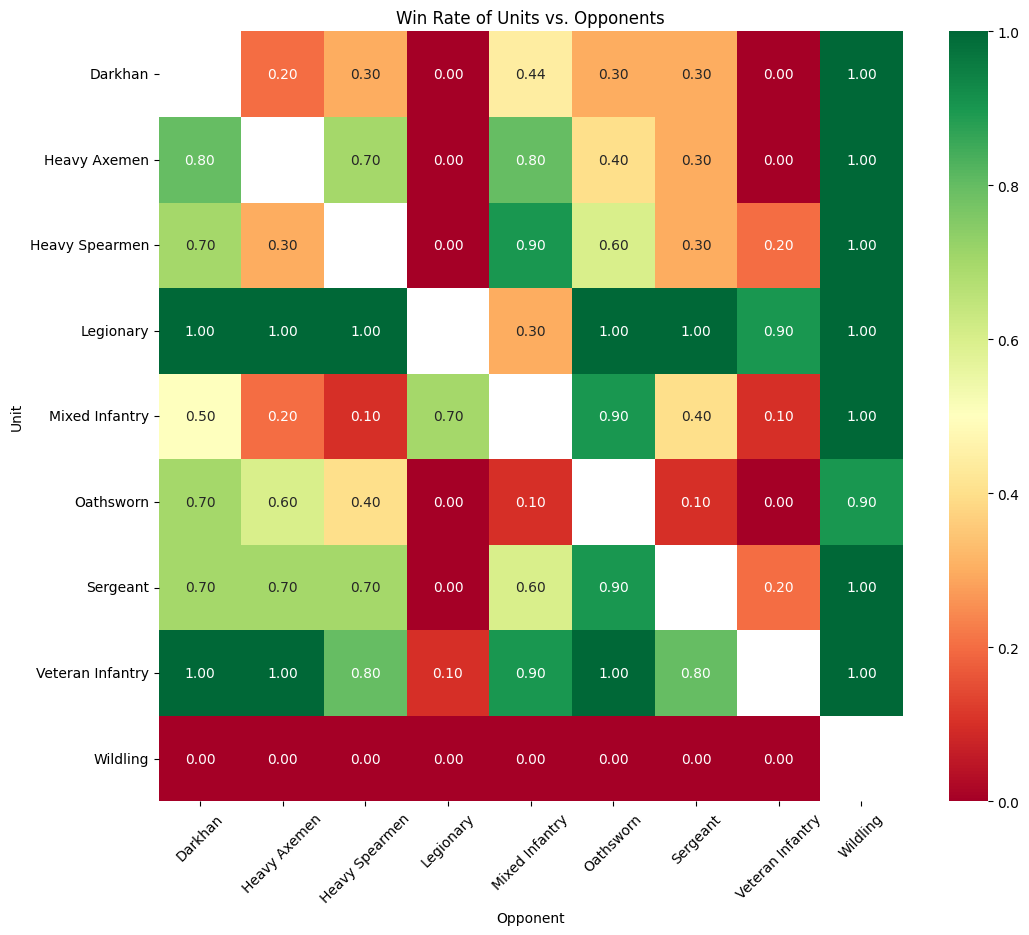

In [40]:
pivot_table = df_3.pivot_table(values='win', index='unit', columns='opponent', aggfunc='mean')
title_9 = 'Win Rate of Units vs. Opponents'
# Plot the heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(pivot_table, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title(title_9)
plt.xlabel('Opponent')
plt.ylabel('Unit')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

## Conclusion and Key Takeaways

Overall, I think that the Legionary and the Veteran Infantry are the best performing shield infantry units in Bannerlord. They are efficient and have win more times than they lose. The worst performing unit is the Wildling. I did not expect the Legionary and Veteran Infantry to be a whole head higher than the other units, as I thought that performances more or less be similar. 

Some key takeaways:
- Legionary wins against every other shield infantry unit, except when it is outnumbered.
- Veteran Infantry wins, even when outnumbered. They are only countered by Legionary.
- Sergeants are a solid overall unit, they win against all except Legionary and Veteran Infantry, and can win while outnumbered.
- Heavy Spearmen and Axemen are similar performers, but I would give the edge to the Spearmen since they have a long spear that can counter cavalry units.
- Darkhans are not to be underestimated, they may lose a lot but they will bring a lot of your units to the grave with them.
- Oathsworn are too unreliable to be considered for your army, they are inefficient (<1 KDR) and have a have a sub 50% win rate.
- Wildlings are not worth it as a main shield infantry unit.

I also want to note that some of these shield infantry units have ranged capabilities but during the data collection process, ranged capabilities were turned off. The Veteran Infantry have five javelins, and the Heavy Axemen and Wildlings have ten javelins each. If ranged capabilities were on, then all three could have higher performance outputs. Also, I think it is also worth considering the Heavy Axemen and Wildlings as skirmisher units with defensive capabilites rather than frontline soldiers like the Legionary or Sergeants. 

It is worth noting that have shield-infantry unit is only a piece of the puzzle when it comes to creating an army. A strong line of shield infantry stop the an opposing army from gaining ground, push forward towards the opposing army, soak up arrows from archers, and prevent opposing cavalry from breaking formations. The point is that they are important but require support to be effective, like from archers and cavalry. Tactics are also extremely important in this game, so units can perform better when commanded by the player.

If someone wanted to create the "perfect" army that performs well against everyone else, then they should make their main shield infantry units the Legionary or Veteran Infantry.

Here are my tiered rankings as to which shield infantry units are the best:

- S: Legionary, Veteran Infantry
- A: Sergeant
- B: Heavy Spearmen, Heavy Axemen
- C: Darkhan
- D: Oathsworn
- F: Wildling

## Future Considerations

I would like to know why the Legionary and Veteran Infantry perform so well, and why the Wildlings perform poorly. What differentiates these units are their skill levels and equipment, so I think performing a skill and equipment analysis will be helpful. Each unit shares the same skills, however their skills may differ (e.g. Veteran Infantry have 160 one-handed skill, and the Wildling have 120 one-handed skill), and they use different equipment (e.g. Legionary have higher arm armor ratings than Heavy Axemen). 